# Bench Mark

rfc + naive: 0.686

In [16]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    AdaBoostClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler

from skopt import BayesSearchCV
from skopt.space import (
    Real, 
    Categorical, 
    Integer
)

import RecursiveFeatureSelector

import pickle

import itertools

from nba_util import (
    who_won, 
    get_streak, 
    get_count, 
    get_match_count,
    get_match_specific_streak, 
    get_match_specific_count, 
    get_match_specific_match_count, 
    get_match_specific_pct,
    get_odd_ratio,
    get_ewm,
    get_match_specific_ewm,
    encode,
    elo_score,
    elo_update,
    shift_elo
)

In [39]:
df = pd.read_csv("dataframe/nba.csv")
df = df[['match_name', 'result', 'h_odd', 'a_odd', 'n_bookmakers_odd', 'datetime']]

In [40]:
df = df[df.h_odd != '-'].copy()
df = df[df.a_odd != '-'].copy()

# get 'home_team' and 'away_home' by splitting 'match_name'
df['home_team'] = df.match_name.apply(lambda x: x.split("-")[0].strip(" "))
df['away_team'] = df.match_name.apply(lambda x: x.split("-")[1].strip(" "))

# remove postponed matches
df = df[~(df.result == "postp.")].copy()

# get feature 'home_score' and 'away_score'
df['home_score'] = df.result.apply(lambda x: x.split(":")[0]).astype(int)
df['away_score'] = df.result.apply(lambda x: x.split(":")[1]).astype(int)

df['datetime'] = pd.to_datetime(df.datetime)

In [4]:
# Last score
df = pd.merge(df, df.groupby('home_team').apply(lambda x: x.sort_values('datetime').shift(1))[['home_score', 'away_score']].reset_index().rename(columns={"home_score":"prev_home_score", "away_score":"prev_away_score"}).set_index('level_1').drop('home_team', axis=1), left_index=True, right_index=True)
df['prev_home_score'].fillna(df['prev_home_score'].mean(), inplace=True)
df['prev_away_score'].fillna(df['prev_away_score'].mean(), inplace=True)

# Last score spread
df['prev_score_spread'] = df['prev_home_score'] - df['prev_away_score']

# Last score spread
df['prev_score_ratio'] = df['prev_home_score'] / df['prev_away_score']

In [5]:
df = df[df.h_odd != '-'].copy()
df = df[df.a_odd != '-'].copy()

# get 'home_team' and 'away_home' by splitting 'match_name'
df['home_team'] = df.match_name.apply(lambda x: x.split("-")[0].strip(" "))
df['away_team'] = df.match_name.apply(lambda x: x.split("-")[1].strip(" "))

# remove postponed matches
df = df[~(df.result == "postp.")].copy()

# get feature 'home_score' and 'away_score'
df['home_score'] = df.result.apply(lambda x: x.split(":")[0])
df['away_score'] = df.result.apply(lambda x: x.split(":")[1])


# get target 'winner'
df['winner'] = df.result.apply(who_won)


df = get_match_specific_match_count(df)
for i in ['home', 'away']:
    df = get_match_count(df, i)
    for j in ['win', 'lose', 'draw']:
        df = get_streak(df, i, j)
        df = get_count(df, i, j)
        df = get_match_specific_streak(df, i, j)
        df = get_match_specific_count(df, i, j)
        df = get_match_specific_pct(df, i, j)       
        
for k in ['home', 'away']:
    for l in ['home', 'away']:
        if k != l:
            df = get_odd_ratio(df, k, l)

df['odd_spread'] = df.h_odd.astype(float) - df.a_odd.astype(float)

df = get_ewm(df)
df = get_match_specific_ewm(df)


# Label Encoding
teams = list(set(df.home_team.to_list() + df.away_team.to_list()))
encoding = {k:v for k, v in zip(teams, range(len(teams)))}

df['home_team_en'] = df.home_team.replace(encoding)
df['away_team_en'] = df.away_team.replace(encoding)

# Cyclical Encoding
df['month'] = pd.to_datetime(df.datetime).dt.month
df = encode(df, 'month', 12)

df['day'] = pd.to_datetime(df.datetime).dt.day
df = encode(df, 'day', 365)

seconds_in_day = 24*60*60
time_in_sec = df.datetime.dt.hour * 3600 + df.datetime.dt.minute * 60
df['sin_time'] = np.sin(2 * np.pi * time_in_sec / seconds_in_day)
df['cos_time'] = np.cos(2 * np.pi * time_in_sec / seconds_in_day)

df['home_score'] = df.home_score.astype(int)
df['away_score'] = df.away_score.astype(int)

In [6]:
elo = {}
df.loc[:, 'home_elo'] = np.nan
df.loc[:, 'away_elo'] = np.nan
df.sort_values('datetime', inplace=True)
for dt, h, a, h_s, a_s in zip(df.datetime, df.home_team, df.away_team, df.home_score, df.away_score):
    # Calulate expected score
    if h in elo:
        ra = elo[h]
        
    if a in elo:
        rb = elo[a]
        
    if h not in elo:
        elo[h] = 0
        ra = elo[h]
        
    if a not in elo:
        elo[a] = 0
        rb = elo[a]
        
    ea, eb = elo_score(ra=h_s, rb=a_s)
    
    # Calculate elo change
    ra_prime, rb_prime = elo_update(
        ra=ra, 
        sa=h_s,
        ea=ea, 
        rb=rb, 
        sb=a_s,
        eb=eb,
        k=20
    )
    
    elo[h] = ra_prime
    elo[a] = rb_prime
    
    df.loc[(df.datetime == dt) & (df.home_team == h), 'home_elo'] = ra_prime
    df.loc[(df.datetime == dt) & (df.away_team == a), 'away_elo'] = rb_prime
    
df = shift_elo(df, 0)

draws_col = [c for c in df.columns if 'draw' in c]
df.drop(draws_col, axis=1, inplace=True)

In [248]:
df.isnull().sum().sum()

0

In [7]:
# Features selected for model building
features = [
    'h_odd',
    'a_odd',
    'n_bookmakers_odd',
    'match_specific_total_match_count',
    'h_total_match_count',
    'h_win_streak',
    'h_win_counts',
    'h_match_specific_win_streak',
    'h_match_specific_win_counts',
    'h_match_specific_%win',
    'h_lose_streak',
    'h_lose_counts',
    'h_match_specific_lose_streak',
    'h_match_specific_lose_counts',
    'h_match_specific_%lose',
    'a_total_match_count',
    'a_win_streak',
    'a_win_counts',
    'a_match_specific_win_streak',
    'a_match_specific_win_counts',
    'a_match_specific_%win',
    'a_lose_streak',
    'a_lose_counts',
    'a_match_specific_lose_streak',
    'a_match_specific_lose_counts',
    'a_match_specific_%lose',
    'h_to_a_odd_ratio',
    'a_to_h_odd_ratio',
    'odd_spread',
    'h_total_match_count_ewm',
    'h_win_streak_ewm',
    'h_win_counts_ewm',
    'h_lose_streak_ewm',
    'a_total_match_count_ewm',
    'a_win_streak_ewm',
    'a_win_counts_ewm',
    'a_lose_streak_ewm',
    'h_match_specific_win_streak_ewm',
    'h_match_specific_win_counts_ewm',
    'h_match_specific_lose_streak_ewm',
    'a_match_specific_win_streak_ewm',
    'a_match_specific_win_counts_ewm',
    'a_match_specific_lose_streak_ewm',
    'home_elo',
    'away_elo',
    'home_team_en',
    'away_team_en',
    'month',
    'month_sin',
    'month_cos',
    'day',
    'day_sin',
    'day_cos',
    'sin_time',
    'cos_time',
    'prev_score_spread',
    'prev_home_score',
    'prev_away_score',
    'prev_score_ratio',
]

In [8]:
# Sort values by datime before preprocessing
df.sort_values('datetime', ascending=True, inplace=True)
df.sort_index(inplace=True)

# Define X and y
X = df[features]
y = df['winner']

# Spiltting the dataframe
N = int(len(X) * .7)
X_train = X[:N]
X_test = X[N:]

y_train = y[:N]
y_test = y[N:]

# Splitting validation set from test set
N2 = int(len(X_test) * .5)
X_val = X_test[N2:]
y_val = y_test[N2:]

X_test = X_test[:N2]
y_test = y_test[:N2]

# Remove rows that odds are '-'
no_odds_idx = X_train[X_train.h_odd == '-'].index
X_train = X_train.drop(no_odds_idx).astype(float)
y_train = y_train.drop(no_odds_idx).astype(float)
X_test = X_test.astype(float)
X_val = X_val.astype(float)

In [ ]:
# Normaliing with Yeo-Johnson



In [9]:
# Scale the dataframes
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Turn the scaled numpy arrays back to pandas dataframes
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)
X_val = pd.DataFrame(X_val, columns=features)

In [252]:
# Instantiate the models
estimators = [
    XGBClassifier(use_label_encoder=False, verbosity=0), 
    CatBoostClassifier(verbose=0), 
    RandomForestClassifier(), 
    LogisticRegression(), 
    KNeighborsClassifier(), 
    GradientBoostingClassifier(), 
    AdaBoostClassifier(), 
    MLPClassifier()
]

estimators_str = ['xgbc', 'cat', 'rfc', 'lr', 'knn', 'gb', 'ada', 'mlp']
scores_train = {}
scores_test = {}
scores_val = {}
classification_reports = {}

for e, s in zip(estimators, estimators_str):
    e.fit(X_train, y_train)
    y_pred_train = e.predict(X_train)
    y_pred_test = e.predict(X_test)
    y_pred_val = e.predict(X_val)
    
    acc_train = accuracy_score(y_pred_train, y_train)
    acc_test = accuracy_score(y_pred_test, y_test)
    acc_val = accuracy_score(y_pred_val, y_val)
    
    scores_train[s] = acc_train
    scores_test[s] = acc_test
    scores_val[s] = acc_val
    
    classification_reports[s] = classification_report(y_test, y_pred_test)
    
scores = pd.DataFrame([scores_train, scores_test, scores_val], index=['train', 'test', 'val'])

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: 

In [253]:
print(scores.to_markdown())

|       |     xgbc |      cat |      rfc |       lr |      knn |       gb |      ada |      mlp |
|:------|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| train | 0.966593 | 0.831562 | 1        | 0.694311 | 0.750964 | 0.723514 | 0.700385 | 0.825955 |
| test  | 0.605995 | 0.646866 | 0.60218  | 0.680109 | 0.59346  | 0.611444 | 0.634877 | 0.620163 |
| val   | 0.570027 | 0.612534 | 0.570572 | 0.647411 | 0.546594 | 0.580926 | 0.568937 | 0.584196 |


|       |     xgbc |      cat |      rfc |       lr |      knn |       gb |      ada |      mlp |
|:------|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| train | 0.966593 | 0.831562 | 1        | 0.694311 | 0.750964 | 0.723514 | 0.700385 | 0.825955 |
| test  | 0.605995 | 0.646866 | 0.60218  | 0.680109 | 0.59346  | 0.611444 | 0.634877 | 0.620163 |
| val   | 0.570027 | 0.612534 | 0.570572 | 0.647411 | 0.546594 | 0.580926 | 0.568937 | 0.584196 |

 
Total Time Spent: 57.51(s)


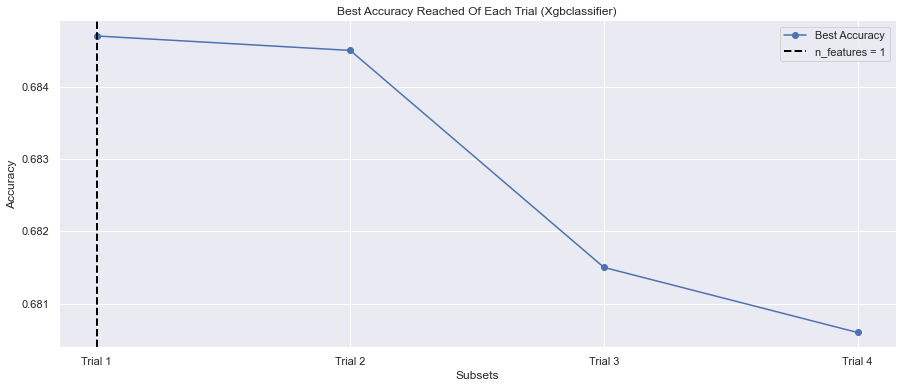

--------------------------------End of Recursive Features Selection (XGBClassifier)-------------------------------
 
Total Time Spent: 121.56(s)


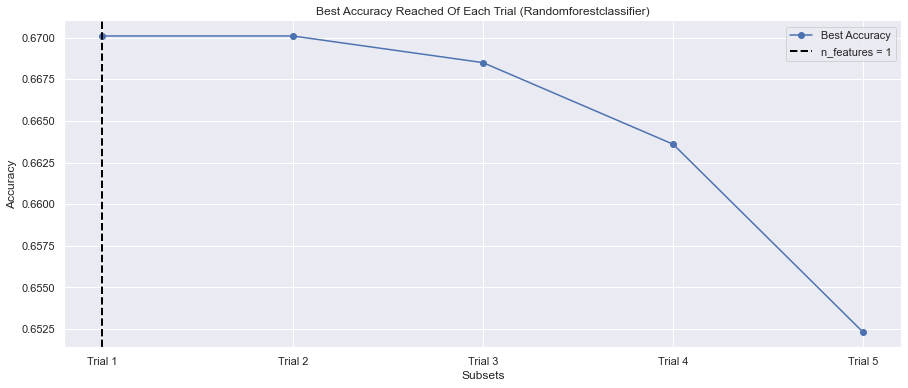

--------------------------------End of Recursive Features Selection (RandomForestClassifier)-------------------------------
 
Total Time Spent: 1307.96(s)


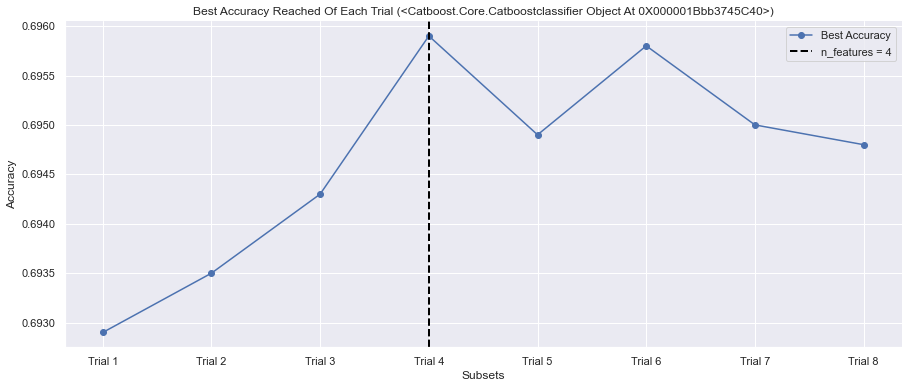

--------------------------------End of Recursive Features Selection (<catboost.core.CatBoostClassifier object at 0x000001BBB3745C40>)-------------------------------
 
Total Time Spent: 1323.22(s)


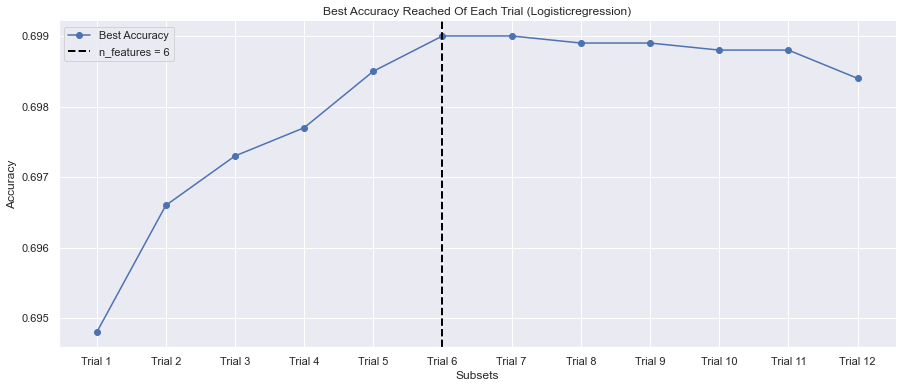

--------------------------------End of Recursive Features Selection (LogisticRegression)-------------------------------
 
Total Time Spent: 1363.1(s)


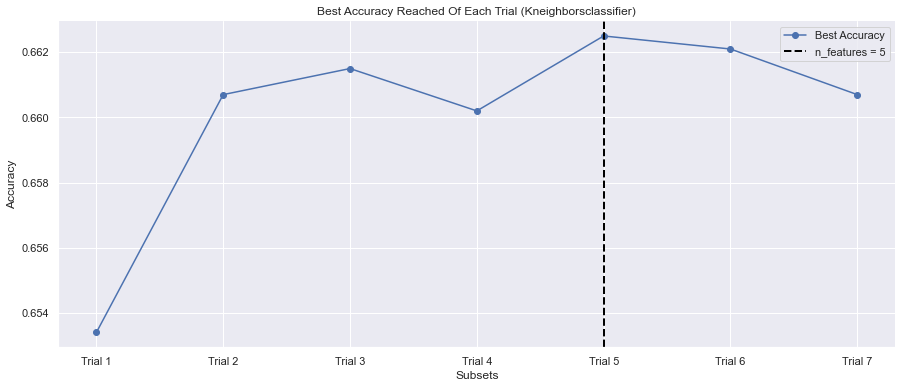

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Total Time Spent: 1468.03(s)


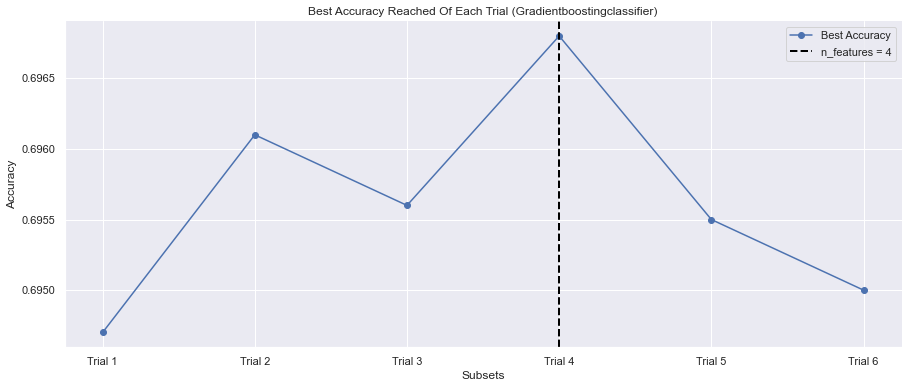

--------------------------------End of Recursive Features Selection (GradientBoostingClassifier)-------------------------------
 
Total Time Spent: 1645.0(s)


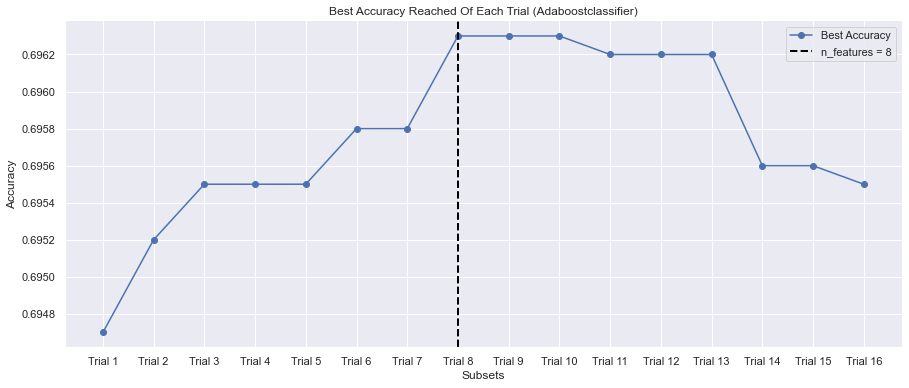

--------------------------------End of Recursive Features Selection (AdaBoostClassifier)-------------------------------
 
Total Time Spent: 2527.46(s)


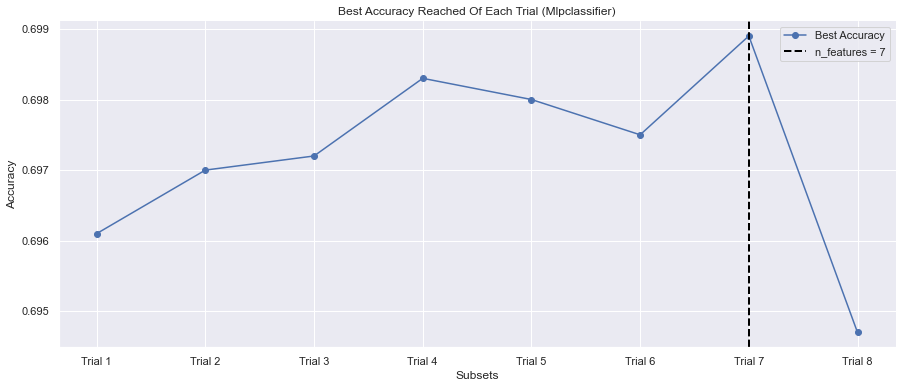

--------------------------------End of Recursive Features Selection (MLPClassifier)-------------------------------


In [254]:
# Instantiate the models
estimators = [
    XGBClassifier(use_label_encoder=False, verbosity=0, n_jobs=-1), 
    RandomForestClassifier(n_jobs=-1),
    CatBoostClassifier(verbose=0), 
    LogisticRegression(n_jobs=-1), 
    KNeighborsClassifier(n_jobs=-1), 
    GradientBoostingClassifier(), 
    AdaBoostClassifier(), 
    MLPClassifier()
]

rfs = RecursiveFeatureSelector.RecursiveFeatureSelector()
rfs.fit(X_train, y_train)
rfs.search(estimators, cv=3, scoring='accuracy', verbose=1, tolerance=3)

In [255]:
rfs.summaries

{'XGBClassifier':                                            Best Subset Best Accuracy  \
 Trial 1                                        [a_odd]        0.6847   
 Trial 2                            [a_odd, odd_spread]        0.6845   
 Trial 3                 [a_odd, odd_spread, month_sin]        0.6815   
 Trial 4  [a_odd, odd_spread, month_sin, a_lose_streak]        0.6806   
 
         Time Spent  
 Trial 1      14.83  
 Trial 2      13.29  
 Trial 3       14.2  
 Trial 4      15.18  ,
 'RandomForestClassifier':                                                Best Subset Best Accuracy  \
 Trial 1                                            [h_odd]        0.6701   
 Trial 2              [h_odd, a_match_specific_lose_streak]        0.6701   
 Trial 3  [h_odd, a_match_specific_lose_streak, h_match_...        0.6685   
 Trial 4  [h_odd, a_match_specific_lose_streak, h_match_...        0.6636   
 Trial 5  [h_odd, a_match_specific_lose_streak, h_match_...        0.6523   
 
         Time S

In [256]:
rfs.best_subsets

{'XGBClassifier': ['a_odd'],
 'RandomForestClassifier': ['h_odd'],
 '<catboost.core.CatBoostClassifier object at 0x000001BBB3745C40>': ['a_odd',
  'h_odd',
  'cos_time',
  'a_to_h_odd_ratio'],
 'LogisticRegression': ['odd_spread',
  'h_match_specific_%lose',
  'a_win_streak_ewm',
  'h_match_specific_lose_counts',
  'sin_time',
  'prev_away_score'],
 'KNeighborsClassifier': ['h_to_a_odd_ratio',
  'h_match_specific_win_counts_ewm',
  'a_match_specific_win_counts_ewm',
  'h_match_specific_win_counts',
  'month_cos'],
 'GradientBoostingClassifier': ['a_odd',
  'cos_time',
  'h_win_streak',
  'sin_time'],
 'AdaBoostClassifier': ['a_odd',
  'h_match_specific_win_streak_ewm',
  'a_lose_streak',
  'a_match_specific_win_streak_ewm',
  'day',
  'a_win_streak_ewm',
  'a_lose_streak_ewm',
  'month'],
 'MLPClassifier': ['a_odd',
  'sin_time',
  'a_win_streak',
  'h_match_specific_%lose',
  'away_team_en',
  'a_to_h_odd_ratio',
  'h_match_specific_lose_streak_ewm']}

In [259]:
xgb_col = ['a_odd']
rfc_col = ['h_odd']
cat_col = ['a_odd',
  'h_odd',
  'cos_time',
  'a_to_h_odd_ratio']
knn_col = ['h_to_a_odd_ratio',
  'h_match_specific_win_counts_ewm',
  'a_match_specific_win_counts_ewm',
  'h_match_specific_win_counts',
  'month_cos']
gbc_col = ['a_odd',
  'cos_time',
  'h_win_streak',
  'sin_time']
ada_col = ['a_odd',
  'h_match_specific_win_streak_ewm',
  'a_lose_streak',
  'a_match_specific_win_streak_ewm',
  'day',
  'a_win_streak_ewm',
  'a_lose_streak_ewm',
  'month']
mlp_col = ['a_odd',
  'sin_time',
  'a_win_streak',
  'h_match_specific_%lose',
  'away_team_en',
  'a_to_h_odd_ratio',
  'h_match_specific_lose_streak_ewm']

In [257]:
# Instantiate the models
estimators = [
    XGBClassifier(use_label_encoder=False, verbosity=0), 
    RandomForestClassifier(n_jobs=7),
    CatBoostClassifier(verbose=0), 
    LogisticRegression(n_jobs=7), 
    KNeighborsClassifier(n_jobs=7), 
    GradientBoostingClassifier(), 
    AdaBoostClassifier(), 
    MLPClassifier()
]

scores_train = {}
scores_test = {}
scores_val = {}

for e, i in zip(estimators, rfs.best_subsets.items()):
    k = i[0]
    v = i[1]
    
    e.fit(X_train[v], y_train)
    
    y_pred_train = e.predict(X_train[v])
    y_pred_test = e.predict(X_test[v])
    y_pred_val = e.predict(X_val[v])
    
    acc_train = accuracy_score(y_pred_train, y_train)
    acc_test = accuracy_score(y_pred_test, y_test)
    acc_val = accuracy_score(y_pred_val, y_val)
    
    scores_train[k] = acc_train
    scores_test[k] = acc_test
    scores_val[k] = acc_val
    
scores = pd.DataFrame([scores_train, scores_test, scores_val], index=['train', 'test', 'val'])

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-pack

In [258]:
print(scores.to_markdown())

|       |   XGBClassifier |   RandomForestClassifier |   <catboost.core.CatBoostClassifier object at 0x000001BBB3745C40> |   LogisticRegression |   KNeighborsClassifier |   GradientBoostingClassifier |   AdaBoostClassifier |   MLPClassifier |
|:------|----------------:|-------------------------:|------------------------------------------------------------------:|---------------------:|-----------------------:|-----------------------------:|---------------------:|----------------:|
| train |        0.702138 |                 0.711132 |                                                          0.711833 |             0.697816 |               0.768952 |                     0.704357 |             0.699451 |        0.707744 |
| test  |        0.673569 |                 0.678474 |                                                          0.675749 |             0.678474 |               0.622343 |                     0.679564 |             0.677384 |        0.684469 |
| val   |        0.653951 | 

|naive  |     xgbc |      cat |      rfc |       lr |      knn |       gb |      ada |      mlp |
|:------|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| train | 0.966593 | 0.831562 | 1        | 0.694311 | 0.750964 | 0.723514 | 0.700385 | 0.825955 |
| test  | 0.605995 | 0.646866 | 0.60218  | 0.680109 | 0.59346  | 0.611444 | 0.634877 | 0.620163 |
| val   | 0.570027 | 0.612534 | 0.570572 | 0.647411 | 0.546594 | 0.580926 | 0.568937 | 0.584196 |
|RFS    |     xgbc |      cat |      rfc |       lr |      knn |       gb |      ada |      mlp |
|:------|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| train | 0.702138 | 0.711132 | 0.711833 | 0.697816 | 0.768952 | 0.704357 | 0.699451 | 0.707744 |
| test  | 0.673569 | 0.678474 | 0.675749 | 0.678474 | 0.622343 | 0.679564 | 0.677384 | 0.684469 |
| val   | 0.653951 | 0.647411 | 0.652861 | 0.656676 | 0.617984 | 0.659401 | 0.658311 | 0.645232 |

In [19]:
df['winner'].value_counts(normalize=True) * 100

0    59.242907
1    40.757093
Name: winner, dtype: float64

In [260]:
opt = BayesSearchCV(
    XGBClassifier(use_label_encoder=False, verbosity=0, n_jobs=-1),
    {
    'n_estimators': Integer(1, 100000),
    'learning_rate': Real(1e-6, 1, prior='log-uniform'),
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    },
    cv=3,
    scoring="accuracy"
)

opt.fit(X_train[xgb_col], y_train)
    
print("CV score: %s" % opt.best_score_)
print("Train score: %s" % opt.score(X_train[xgb_col], y_train))
print("Test score: %s" % opt.score(X_test[xgb_col], y_test))
print("Validation score: %s" % opt.score(X_val[xgb_col], y_val))
print("best params: %s" % str(opt.best_params_))

# rfs
# CV score: 0.695479409872182
# Train score: 0.6980492933068567
# Test score: 0.68283378746594
# Validation score: 0.662125340599455
# best params: OrderedDict([('gamma', 9.571344436717936), ('learning_rate', 0.0018193945101586493), ('n_estimators', 1600)])



C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-pack

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-pack

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-pack

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-pack

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-pack

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-pack

CV score: 0.695479409872182
Train score: 0.6980492933068567
Test score: 0.68283378746594
Validation score: 0.662125340599455
best params: OrderedDict([('gamma', 9.571344436717936), ('learning_rate', 0.0018193945101586493), ('n_estimators', 1600)])


C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [261]:
opt = BayesSearchCV(
    RandomForestClassifier(n_jobs=-1),
    {
    'n_estimators': Integer(1, 100000),
    'criterion': Categorical(['gini', 'entropy']),
    'max_depth': Integer(1,16)
    },
    cv=3,
    scoring="accuracy"
)

opt.fit(X_train[rfc_col], y_train)

print("CV score: %s" % opt.best_score_)
print("Train score: %s" % opt.score(X_train[rfc_col], y_train))
print("Test score: %s" % opt.score(X_test[rfc_col], y_test))
print("Validation score: %s" % opt.score(X_val[rfc_col], y_val))
print("best params: %s" % str(opt.best_params_))


# rfs
# CV score: 0.6938436638287863
# Train score: 0.6973484406027334
# Test score: 0.6806539509536784
# Validation score: 0.6615803814713896
# best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 2), ('n_estimators', 91655)])


C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimize

CV score: 0.6938436638287863
Train score: 0.6973484406027334
Test score: 0.6806539509536784
Validation score: 0.6615803814713896
best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 2), ('n_estimators', 92966)])


In [17]:
opt = BayesSearchCV(
    CatBoostClassifier(verbose=0),
    {
    'n_estimators': Integer(1, 10000),
    'learning_rate': Real(1e-4, 0.1, prior='log-uniform'),
    'max_depth': Integer(1,16)
    },
    cv=3,
    scoring="accuracy"
)

opt.fit(X_train, y_train)

print("CV score: %s" % opt.best_score_)
print("Train score: %s" % opt.score(X_train, y_train))
print("Test score: %s" % opt.score(X_test, y_test))
print("Validation score: %s" % opt.score(X_val, y_val))
print("best params: %s" % str(opt.best_params_))



KeyboardInterrupt: 

In [262]:
opt = BayesSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    {
    'n_neighbors': Integer(1, X_val.shape[1]),
    'leaf_size': Integer(2, 50),
    'weights': Categorical(['uniform', 'distance']),
    },
    cv=3,
    scoring="accuracy"
)

opt.fit(X_train[knn_col], y_train)

print("CV score: %s" % opt.best_score_)
print("Train score: %s" % opt.score(X_train[knn_col], y_train))
print("Test score: %s" % opt.score(X_test[knn_col], y_test))
print("Validation score: %s" % opt.score(X_val[knn_col], y_val))
print("best params: %s" % str(opt.best_params_))

# rfs
# CV score: 0.6866015053759744
# Train score: 0.7040065412919051
# Test score: 0.6659400544959128
# Validation score: 0.6425068119891009
# best params: OrderedDict([('leaf_size', 2), ('n_neighbors', 51), ('weights', 'uniform')])


C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CV score: 0.6866015053759744
Train score: 0.7040065412919051
Test score: 0.6659400544959128
Validation score: 0.6425068119891009
best params: OrderedDict([('leaf_size', 2), ('n_neighbors', 51), ('weights', 'uniform')])


In [263]:
opt = BayesSearchCV(
    LogisticRegression(verbose=0, n_jobs=-1),
    {
    'penalty':Categorical(['l2', 'none']),
    'C': Real(1e-6, 10, prior='log-uniform'),
    'max_iter': Integer(100, 100000),
    'l1_ratio': Real(1e-6, 1)
    },
    cv=3,
    scoring="accuracy"
)

opt.fit(X_train, y_train)

print("CV score: %s" % opt.best_score_)
print("Train score: %s" % opt.score(X_train, y_train))
print("Test score: %s" % opt.score(X_test, y_test))
print("Validation score: %s" % opt.score(X_val, y_val))
print("best params: %s" % str(opt.best_params_))

# rfs
# CV score: 0.6884704323254236
# Train score: 0.6953626912743839
# Test score: 0.6806539509536784
# Validation score: 0.6523160762942779
# best params: OrderedDict([('C', 2.1872540589291827), ('l1_ratio', 0.5253121542349342), ('max_iter', 5168), ('penalty', 'none')])


C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parame

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: User

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parame

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: S

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parame

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_

CV score: 0.6884704323254236
Train score: 0.6953626912743839
Test score: 0.6806539509536784
Validation score: 0.6523160762942779
best params: OrderedDict([('C', 2.1872540589291827), ('l1_ratio', 0.5253121542349342), ('max_iter', 5168), ('penalty', 'none')])


In [264]:
opt = BayesSearchCV(
    MLPClassifier(),
    {
    'hidden_layer_sizes':Integer(1, 10000),
    'learning_rate': Categorical(['constant', 'invscaling', 'adaptive']),
    'activation': Categorical(['identity', 'logistic', 'tanh', 'relu']),
    'solver': Categorical(['adam']),
    'max_iter': Integer(1, 10000)
    },
    cv=3,
    scoring="accuracy"
)

opt.fit(X_train[mlp_col], y_train)

print("CV score: %s" % opt.best_score_)
print("Train score: %s" % opt.score(X_train[mlp_col], y_train))
print("Test score: %s" % opt.score(X_test[mlp_col], y_test))
print("Validation score: %s" % opt.score(X_val[mlp_col], y_val))
print("best params: %s" % str(opt.best_params_))

# naive
# CV score: 0.6985162472971934
# Train score: 0.6983997196589183
# Test score: 0.6801089918256131
# Validation score: 0.6604904632152588
# best params: OrderedDict([
#     ('activation', 'tanh'), 
#     ('hidden_layer_sizes', 1), 
#     ('learning_rate', 'invscaling'), 
#     ('max_iter', 10000), 
#     ('solver', 'adam')
# ])

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (148) reached and the optimization h

CV score: 0.6923253679292577
Train score: 0.6931433243779932
Test score: 0.6773841961852861
Validation score: 0.6632152588555859
best params: OrderedDict([('activation', 'logistic'), ('hidden_layer_sizes', 2714), ('learning_rate', 'adaptive'), ('max_iter', 267), ('solver', 'adam')])


|naive  |     xgbc |      cat |      rfc |       lr |      knn |       gb |      ada |      mlp |
|:------|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| train | 0.96741  | 0.836818 | 1        | 0.696881 | 0.752716 | 0.720827 | 0.698283 | 0.80236  |
| test  | 0.579292 | 0.662125 | 0.648501 | 0.671935 | 0.609264 | 0.575477 | 0.679564 | 0.626703 |
| val   | 0.560763 | 0.646322 | 0.626703 | 0.649591 | 0.564578 | 0.535695 | 0.657221 | 0.589101 |
|RFS    |---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| train | 0.702138 | 0.711132 | 0.724682 | 0.700035 | 0.771288 | 0.703656 | 0.698517 | 0.697699 |
| test  | 0.673569 | 0.673569 | 0.678474 | 0.683924 | 0.627793 | 0.682834 | 0.681744 | 0.675204 |
| val   | 0.653951 | 0.644687 | 0.658856 | 0.66049  | 0.608174 | 0.66049  | 0.66158  | 0.66158  |
|RFS+hy |---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| train | 0.698049 | -------- | 0.697348 | 0.700035 | 0.700852 | -------- | -------- | 0.698399 |
| test  | 0.682833 | -------- | 0.680653 | 0.683923 | 0.676294 | -------- | -------- | 0.680108 |
| val   | 0.662125 | -------- | 0.661580 | 0.660490 | 0.658855 | -------- | -------- | 0.660490 |

In [28]:
xgbc = XGBClassifier(
    use_label_encoder=False, 
    verbosity=0,
    gamma=5.332413877120902, 
    learning_rate=0.03101989269625406, 
    n_estimators=91649
    )

cat = CatBoostClassifier(verbose=0)

rfc = RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=91655, n_jobs=-1)

lr = LogisticRegression(C=0.6935823891096489, l1_ratio=1.0, max_iter=100, penalty='l2', n_jobs=-1)

knn = KNeighborsClassifier(leaf_size=50, n_neighbors=54, weights='uniform')

gbc = GradientBoostingClassifier()

ada = AdaBoostClassifier()

mlp = MLPClassifier(
    activation='tanh', 
    hidden_layer_sizes=1, 
    learning_rate='invscaling', 
    max_iter=10000, 
    solver='adam'
)


xgbc.fit(X_train[xgb_col], y_train)
cat.fit(X_train[cat_col], y_train)
rfc.fit(X_train[rfc_col], y_train)
lr.fit(X_train[lr_col], y_train)
knn.fit(X_train[knn_col], y_train)
gbc.fit(X_train[gbc_col], y_train)
ada.fit(X_train[ada_col], y_train)
mlp.fit(X_train[mlp_col], y_train)

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


MLPClassifier(activation='tanh', hidden_layer_sizes=1,
              learning_rate='invscaling', max_iter=10000)

In [31]:
y_pred_xgbc = xgbc.predict(X_test[xgb_col])
y_pred_cat = cat.predict(X_test[cat_col])
y_pred_rfc = rfc.predict(X_test[rfc_col])
y_pred_lr = lr.predict(X_test[lr_col])
y_pred_knn = knn.predict(X_test[knn_col])
y_pred_gbc = gbc.predict(X_test[gbc_col])
y_pred_ada = ada.predict(X_test[ada_col])
y_pred_mlp = mlp.predict(X_test[mlp_col])

C:\Users\Hindy\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [32]:
import itertools
import pandas as pd
from sklearn.metrics import accuracy_score

class Loop_Stacker:
    def __init__(self, predictions):
        self.predictions = predictions
    
    def fit(self, verbosity=1):
        best_combinations = {}
        best_combinations_frames = {}
        count = 1
        while True:
            print(f"Round: {count}")
            com_keys = [itertools.combinations(self.predictions.keys(), i) for i in range(2, len(self.predictions) + 1)]
            com_vals = [itertools.combinations(self.predictions.values(), i) for i in range(2, len(self.predictions) + 1)]
            
            if len(com_keys) == 0:
                break
            
            curr_best_score = 0
            curr_best_combinations = ""
            for key, val in zip(com_keys, com_vals):
                for k, v in zip(key, val):
                    y_pred = pd.DataFrame(v).mode().iloc[0]
                    score = accuracy_score(y_pred, y_test)

                    if curr_best_score < score:
                        curr_best_score = score
                        curr_best_combinations = k
                        best_combinations[count] = curr_best_combinations
                        best_combinations_frames[count] = y_pred
                        
                        if verbosity > 0:
                            print(k, score)

            for com in curr_best_combinations:
                self.predictions.pop(com)   

            count += 1
            
            if verbosity > 0:
                print("\n")

        y_pred = pd.DataFrame([v for v in best_combinations_frames.values()]).mode().iloc[0]
        all_stacked_score = accuracy_score(y_pred, y_test)
        
        if verbosity > 0:
            print(f"All stacked: {all_stacked_score}")
            
        best_combinations_frames['all_stacked'] = y_pred
        
        self.best_combinations = best_combinations
        self.best_combinations_frames = best_combinations_frames

In [34]:
selected_predictions = {
            "lr":y_pred_lr, 
            "rfc":y_pred_rfc, 
            "xgbc":y_pred_xgbc, 
            "cat":y_pred_cat.ravel(), 
            "knn":y_pred_knn, 
            "gb":y_pred_gbc ,
            "ada":y_pred_ada ,
            "mlp":y_pred_mlp
        }

ls = Loop_Stacker(selected_predictions)
ls.fit()

Round: 1
('lr', 'rfc') 0.68283378746594
('lr', 'rfc', 'knn') 0.6839237057220708
('lr', 'xgbc', 'knn') 0.6844686648501362
('lr', 'rfc', 'cat', 'knn') 0.6861035422343325


Round: 2
('xgbc', 'gb') 0.6822888283378746
('xgbc', 'ada') 0.68283378746594
('xgbc', 'gb', 'mlp') 0.6833787465940054


Round: 3
All stacked: 0.6850136239782016


# Save

In [36]:
# pickle.dump(lr, open('save/lr_premier_league.sav', 'wb'))
# pickle.dump(rfc, open('save/rfc_premier_league.sav', 'wb'))
# pickle.dump(cat, open('save/cat_premier_league.sav', 'wb'))
# pickle.dump(knn, open('save/knn_premier_league.sav', 'wb'))

# BackTesting

In [132]:
def back_test(y_pred):
    odds = []
    for idx, y in enumerate(y_pred):
        if y == 0:
            odd = float(df[df.index.isin(y_val.index)].loc[:, 'h_odd'].iloc[idx])

        if y == 1:
            odd = float(df[df.index.isin(y_val.index)].loc[:, 'a_odd'].iloc[idx])

        odds.append(odd)
    odds = pd.Series(odds)
    
    try:
        correct_pred = y_pred.to_numpy() == y_val.to_numpy()
        
    except:
        correct_pred = y_pred == y_val.to_numpy()
        
    W = odds[correct_pred].astype(float).sum()
    C = (~correct_pred).sum()

    W_and_C_cumsum = np.where(correct_pred, np.array(odds), -1)
    W_and_C_cumsum = pd.Series(W_and_C_cumsum).astype(float).cumsum()

    miu = np.where(correct_pred, np.array(odds), -1).astype(float).mean()
    sigma = np.where(correct_pred, np.array(odds), -1).astype(float).std()
    acc = correct_pred.sum() / len(correct_pred)
    
    return W, C, W_and_C_cumsum, miu, sigma, acc

In [39]:
y_pred_lr = lr.predict(X_val[lr_col])
y_pred_cat = cat.predict(X_val[cat_col])
y_pred_rfc = rfc.predict(X_val[rfc_col])
y_pred_knn = knn.predict(X_val[knn_col])
y_pred = pd.DataFrame(np.vstack([y_pred_lr, y_pred_cat.reshape((1835, )), y_pred_rfc, y_pred_knn]).T).mode(axis=1)[0]

In [130]:
W, C, W_and_C_cumsum, miu, sigma, acc = back_test(y_pred)
sharpe_ratio = miu/sigma
ret_pct = ((P - L)/L * 100) / 1835 

In [134]:
_, _, W_and_C_cumsum_all_home, _, _, _ = back_test(np.zeros((1835, )))
_, _, W_and_C_cumsum_all_away, _, _, _ = back_test(np.ones((1835, )))


    Total Profit:    1739
    Total Loss:      621
    Expected Return: 0.609
    Risk:            1.167
    Accuracy:        0.662
    %Return:         0.098
    


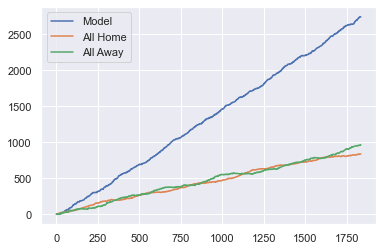

In [137]:
print(
    f'''
    Total Profit:    {round(W)}
    Total Loss:      {C}
    Expected Return: {round(miu, 3)}
    Risk:            {round(sigma, 3)}
    Accuracy:        {round(acc, 3)}
    %Return:         {round(ret_pct, 3)}
    '''
)

W_and_C_cumsum.plot()
W_and_C_cumsum_all_home.plot()
W_and_C_cumsum_all_away.plot()
plt.legend(['Model', 'All Home', 'All Away'])
plt.show()

# Total Profit:    1739
# Total Loss:      621
# Expected Return: 0.609
# Risk:            1.167
# Accuracy:        0.662
# %Return:         0.098